In [1]:
%reload_ext autoreload
%autoreload 2

## Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.assembly import (
    assembly,
    assembly_individual_epochs,
    assembly_run,
    find_sig_assembly,
    assembly_outside_ripples,
    assembly_corrs_deep_sup
)
import nelpy as nel
import nelpy.plotting as npl
import os
import pickle
import glob
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import random
from tqdm import tqdm


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## Plotting defaults

In [3]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

functions.set_plotting_defaults()

## Run main analysis to detect cell assemblies inside of ripples

In [4]:
# load sessions
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
# collect epoch info
epochs_df = pd.DataFrame()
for basepath in df.basepath:
    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs.main(epoch_df)

    epoch_df["basepath"] = basepath
    epochs_df = pd.concat([epochs_df, epoch_df], ignore_index=True)

# search for novel maze indicators with a pre / task / post structure
search_idx = (
    (epochs_df.behavioralParadigm == 1)
    | (epochs_df.behavioralParadigm.str.contains("novel"))
    | (epochs_df.notes.str.contains("novel"))
)
basepaths = []
for basepath in epochs_df[search_idx].basepath.unique():
    idx_bool, idx = functions.find_pre_task_post(
        epochs_df[epochs_df.basepath == basepath].environment
    )
    if idx_bool is not None:
        basepaths.append(basepath)
df = pd.DataFrame()
df["basepath"] = basepaths


In [5]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_awake_task"
assembly_outside_ripples.run(df, save_path, parallel=True)

## load data from cell_assembly

In [6]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_awake_task"

sessions = glob.glob(save_path + os.sep + "*.pkl")

sessions_df = pd.DataFrame()
sessions_df["sessions"] = sessions
not_to_use = (sessions_df["sessions"].str.contains("OMLproject", case=False)) | (
    sessions_df["sessions"].str.contains("ORproject", case=False)
)
sessions_df = sessions_df[~not_to_use]
sessions_df

UID = []
deepSuperficial = []
weights = []
membership = []
df = pd.DataFrame()
assembly_n = 0
assembly_ = []
basepath = []
assembly_path = []
for session in sessions_df.sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    if results is None:
        continue
    if len(results.patterns) == 0:
        continue
    (
        patterns,
        is_member_keep,
        keep_assembly,
        is_member,
    ) = find_sig_assembly.main(results.patterns)

    for i_assemblies, pattern in enumerate(patterns):
        if is_member_keep[i_assemblies].sum() < 2:
            continue
        UID.append(results.cell_metrics["UID"])
        deepSuperficial.append(results.cell_metrics["deepSuperficial"])
        weights.append(pattern)
        # thres = np.mean(pattern) + np.std(pattern) * 2
        # membership.append(pattern > thres)
        membership.append(is_member_keep[i_assemblies])
        assembly_.append([assembly_n] * len(pattern))
        assembly_n += 1
        basepath.append([results.cell_metrics["basepath"].iloc[0]] * len(pattern))
        assembly_path.append([session] * len(pattern))

df["UID"] = np.hstack(UID)
df["basepath"] = np.hstack(basepath)
df["deepSuperficial"] = np.hstack(deepSuperficial)
df["weights"] = np.hstack(weights)
df["membership"] = np.hstack(membership)
df["assembly_n"] = np.hstack(assembly_)
df["assembly_path"] = np.hstack(assembly_path)

df


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,UID,basepath,deepSuperficial,weights,membership,assembly_n,assembly_path
0,1,Z:\Data\AYAold\AYA4\day150804,Deep,-0.108683,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
1,6,Z:\Data\AYAold\AYA4\day150804,Superficial,0.215891,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
2,7,Z:\Data\AYAold\AYA4\day150804,Deep,0.005907,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
3,8,Z:\Data\AYAold\AYA4\day150804,Deep,0.088191,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
4,10,Z:\Data\AYAold\AYA4\day150804,Deep,0.134175,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
...,...,...,...,...,...,...,...
16788,29,Z:\Data\Kenji\nlx_070329,Deep,0.703442,True,195,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
16789,31,Z:\Data\Kenji\nlx_070329,Deep,0.001954,False,195,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
16790,32,Z:\Data\Kenji\nlx_070329,Deep,-0.004306,False,195,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
16791,35,Z:\Data\Kenji\nlx_070329,Deep,0.003578,False,195,Z:\home\ryanh\projects\ripple_heterogeneity\ce...


### add updated deep/sup

In [7]:
df = add_new_deep_sup.add_new_deep_sup_class(df)
df


,UID,basepath,deepSuperficial,weights,membership,assembly_n,assembly_path,deepSuperficialDistance
0,1,Z:\Data\AYAold\AYA4\day150804,middle,-0.108683,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,0.000000
1,6,Z:\Data\AYAold\AYA4\day150804,Superficial,0.215891,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,150.000000
2,7,Z:\Data\AYAold\AYA4\day150804,Deep,0.005907,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,-50.000000
3,8,Z:\Data\AYAold\AYA4\day150804,middle,0.088191,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,0.000000
4,10,Z:\Data\AYAold\AYA4\day150804,middle,0.134175,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,0.000000
...,...,...,...,...,...,...,...,...
16788,29,Z:\Data\Kenji\nlx_070329,Deep,0.703442,True,195,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,-157.133059
16789,31,Z:\Data\Kenji\nlx_070329,Deep,0.001954,False,195,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,-155.520833
16790,32,Z:\Data\Kenji\nlx_070329,Deep,-0.004306,False,195,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,-175.520833
16791,35,Z:\Data\Kenji\nlx_070329,Deep,0.003578,False,195,Z:\home\ryanh\projects\ripple_heterogeneity\ce...,-103.809873


In [8]:
print("n sessions", df.basepath.nunique())
print("n assemblies", df.assembly_n.nunique())
print("")
print("n deep units", (df.deepSuperficial == "Deep").sum())
print("n sup units", (df.deepSuperficial == "Superficial").sum())
print("")
print("n deep members", ((df.deepSuperficial == "Deep") & df.membership).sum())
print("n sup members", ((df.deepSuperficial == "Superficial") & df.membership).sum())


n sessions 21
n assemblies 196

n deep units 5839
n sup units 3249

n deep members 302
n sup members 146


## get assembly identies (deep/sup)

classify assemblies by members' weights

In [9]:
import warnings

warnings.filterwarnings("ignore")


def shuff_labels(df, layer, n_shuff=100):
    weights = []
    for _ in range(n_shuff):
        labels = df["deepSuperficial"].values.copy()
        random.shuffle(labels)

        weights_ = df[(labels == layer)].weights
        weights.append(weights_[weights_ > 0].median())
    return weights

rel_prop_deep_sup = []
prop_deep = []
prop_sup = []
basepath = []
n_deeps = []
n_sups = []
assembly_n = []
n_deep_mem = []
n_sup_mem = []
deep_weights = []
sup_weights = []
deep_rem_weights = []
sup_rem_weights = []
deep_rem_weights_shuff = []
sup_rem_weights_shuff = []
deep_weights_shuff = []
sup_weights_shuff = []
n_members = []
# p_deep = []
# p_sup = []
prop_deep_members = []
prop_sup_members = []
assembly_path = []
sup_weights_mem = []
deep_weights_mem = []
for n_as in tqdm(df.assembly_n.unique()):
    current_df = df[df.assembly_n == n_as]
    n_deep = (current_df.deepSuperficial == "Deep").sum()
    n_sup = (current_df.deepSuperficial == "Superficial").sum()

    n_deep_mem.append(
        ((current_df.deepSuperficial == "Deep") & (current_df.membership)).sum()
    )
    n_sup_mem.append(
        ((current_df.deepSuperficial == "Superficial") & (current_df.membership)).sum()
    )

    deep_weights_ = current_df[(current_df.deepSuperficial == "Deep")].weights
    deep_weights.append(deep_weights_[deep_weights_ > 0].median())

    sup_weights_ = current_df[(current_df.deepSuperficial == "Superficial")].weights
    sup_weights.append(sup_weights_[sup_weights_ > 0].median())

    deep_weights_mem_ = current_df[
        (current_df.deepSuperficial == "Deep") & (current_df.membership)
    ].weights
    deep_weights_mem.append(deep_weights_mem_[deep_weights_mem_ > 0].median())

    sup_weights_mem_ = current_df[
        (current_df.deepSuperficial == "Superficial") & (current_df.membership)
    ].weights
    sup_weights_mem.append(sup_weights_mem_[sup_weights_mem_ > 0].median())

    deep_weights_shuff.append(shuff_labels(current_df, "Deep"))
    sup_weights_shuff.append(shuff_labels(current_df, "Superficial"))

    rel_prop_deep_sup.append(n_deep_mem[-1] / (current_df.membership).sum())

    prop_deep_members.append(
        ((current_df.deepSuperficial == "Deep") & (current_df.membership)).sum()
        / (current_df.membership).sum()
    )
    prop_sup_members.append(
        ((current_df.deepSuperficial == "Superficial") & (current_df.membership)).sum()
        / (current_df.membership).sum()
    )

    n_members.append(current_df.membership.sum())
    prop_deep.append(
        ((current_df.deepSuperficial == "Deep")).sum() / current_df.shape[0]
    )
    prop_sup.append(
        ((current_df.deepSuperficial == "Superficial")).sum() / current_df.shape[0]
    )
    basepath.append(current_df.basepath.unique())
    assembly_path.append(current_df.assembly_path.unique())

    assembly_n.append(n_as)
    n_deeps.append(n_deep)
    n_sups.append(n_sup)

basepath = np.hstack(basepath)
assembly_path = np.hstack(assembly_path)

prop_df = pd.DataFrame()
prop_df["basepath"] = basepath
prop_df["prop_deep"] = prop_deep
prop_df["prop_sup"] = prop_sup
prop_df["rel_prop_deep_sup"] = rel_prop_deep_sup
prop_df["prop_deep_members"] = prop_deep_members
prop_df["prop_sup_members"] = prop_sup_members
prop_df["assembly_n"] = assembly_n
prop_df["n_members"] = n_members
prop_df["n_deep"] = n_deeps
prop_df["n_sup"] = n_sups
prop_df["n_deep_mem"] = n_deep_mem
prop_df["n_sup_mem"] = n_sup_mem
prop_df["deep_weights"] = deep_weights
prop_df["sup_weights"] = sup_weights
prop_df["deep_weights_mem"] = deep_weights_mem
prop_df["sup_weights_mem"] = sup_weights_mem
prop_df["assembly_path"] = assembly_path

labels = [
    "sup" if val == 1 else "deep"
    for val in np.argmax([prop_df.deep_weights, prop_df.sup_weights], axis=0)
]
prop_df["label_by_weight"] = labels


100%|██████████| 196/196 [00:35<00:00,  5.52it/s]


### deep to sup weight ratio

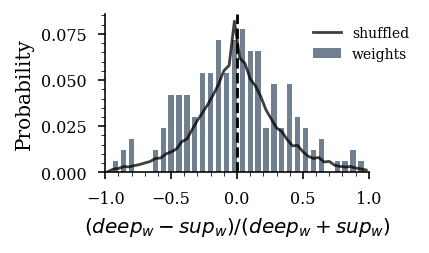

In [10]:
plt.figure(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1, 1)), edgecolor="k"
)
ratio = (prop_df.deep_weights - prop_df.sup_weights) / (
    prop_df.deep_weights + prop_df.sup_weights
)
bin_width = 0.04
x = np.arange(-1, 1, bin_width + bin_width / 2)
binned_ratio, _ = np.histogram(ratio, bins=x)
plt.bar(
    x[:-1] + bin_width / 2,
    binned_ratio / binned_ratio.sum(),
    width=bin_width,
    color="slategrey",
    label="weights",
)

plt.xlim(-1, 1)
plt.axvline(0, color="k", ls="--")
plt.xlabel(r"$(deep_{w} - sup_{w}) / (deep_{w} + sup_{w})$")
plt.ylabel("Probability")

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ratio = (np.hstack(deep_weights_shuff) - np.hstack(sup_weights_shuff)) / (
    np.hstack(deep_weights_shuff) + np.hstack(sup_weights_shuff)
)
# bin_width = .01
x = np.arange(-1, 1 + bin_width / 2, bin_width)
binned_ratio, _ = np.histogram(ratio, bins=x)
plt.plot(
    x[:-1] + bin_width / 2,
    binned_ratio / binned_ratio.sum(),
    color="k",
    alpha=0.75,
    label="shuffled",
)

# plt.legend(frameon=False,loc='best')
plt.legend(
    loc="best", bbox_to_anchor=(0.7, 0.0, 0.5, 1), fontsize="x-small", frameon=False
)

# plt.savefig(os.path.join(fig_save_path,'deep_sup_assembly_weight.svg'),dpi=300,bbox_inches='tight')


### assembly contribution

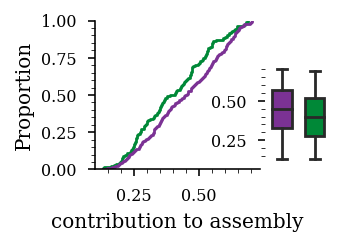

In [11]:
df["weights_abs"] = np.abs(df["weights"])
# make pivot table with weights
# weights_df = pd.DataFrame()
# weights_df["weights"] = np.hstack([df.weights, df.weights])
# weights_df["deepSuperficial"] = np.hstack(
#     [["Deep"] * len(df.weights), ["Superficial"] * len(df.weights)]
# )

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=0.25, subplots=(1.5, 1)),
    edgecolor=None,
)
ax_box = custom_plots.plot_ecdf_box(
    data=df[df.membership],
    x="weights_abs",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    ax=ax,
    x_offset=0.8,
    fig=fig,
)
ax.set_xlabel("contribution to assembly")

plt.savefig(os.path.join(fig_save_path,'contribution_to_assembly_wake_task.svg'),dpi=300,bbox_inches='tight')


In [12]:
print("n sessions", prop_df.basepath.nunique())
# print('n sessions',prop_df.basepath.unique())

print("n assemblies", prop_df.basepath.shape[0])

n_deep = []
n_sup = []
n_deep_mem = []
n_sup_mem = []

for basepath in prop_df.basepath:
    n_deep.append(prop_df[prop_df.basepath == basepath].n_deep.iloc[0])
    n_sup.append(prop_df[prop_df.basepath == basepath].n_sup.iloc[0])
    n_deep_mem.append(prop_df[prop_df.basepath == basepath].n_deep_mem.sum())
    n_sup_mem.append(prop_df[prop_df.basepath == basepath].n_sup_mem.sum())

print("n deep units ", sum(n_deep))
print("n sup units ", sum(n_sup))

print("n deep members ", sum(n_deep_mem))
print("n sup members ", sum(n_sup_mem))


n sessions 21
n assemblies 196
n deep units  5839
n sup units  3249
n deep members  4237
n sup members  2098


### prop of mixed assemblies

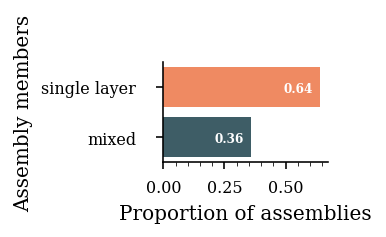

In [13]:
mixed = 0
deep_biased = 0
sup_biased = 0

for n_as in df.assembly_n.unique():
    current_df = df[df.assembly_n == n_as]
    mem_idx = current_df.membership == True
    sup_idx = current_df.deepSuperficial == "Superficial"
    deep_idx = current_df.deepSuperficial == "Deep"

    if ((deep_idx & mem_idx).sum() > 0) & ((sup_idx & mem_idx).sum() > 0):
        mixed += 1
    elif ((deep_idx & mem_idx).sum() > 1) & ((sup_idx & mem_idx).sum() == 0):
        deep_biased += 1
    elif ((deep_idx & mem_idx).sum() == 0) & ((sup_idx & mem_idx).sum() > 0):
        sup_biased += 1

# labels = ["all deep", "mixed", "all sup"]
# counts = [deep_biased, mixed, sup_biased]
labels = ["single layer", "mixed"]
counts = [deep_biased + sup_biased, mixed]


fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=0.25, subplots=(1, 1)), edgecolor=None
)

group_colors = {"same_layer": "#ef8a62", "cross_layer": "#3e5d66"}

# colors = ["#7b3294", "slategrey", "#008837"]
# Horizontal Bar Plot
ax.barh(labels, np.array(counts) / sum(counts), color=group_colors.values())

# Remove axes splines
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(
        i.get_width() - 0.15,
        i.get_y() + 0.5,
        str(round((i.get_width()), 2)),
        fontsize=6,
        fontweight="bold",
        color="w",
        zorder=100,
    )

ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel("Proportion of assemblies")
ax.set_ylabel("Assembly members")

plt.savefig(
    os.path.join(fig_save_path, "assembly_unit_id_wake_task.svg"), dpi=300, bbox_inches="tight"
)


## Example figures

show lolipop fig, assembly strengths, raster, and lfp

In [30]:
basepath = "Z:\Data\AYAold\AB1\day1"
cell_metrics, data, ripples, fs_dat = assembly_run.load_basic_data(basepath)

restrict_idx = (
    (cell_metrics.putativeCellType == "Pyramidal Cell")
    & (cell_metrics.brainRegion.str.contains("CA1"))
    & (cell_metrics.bad_unit == False)
)

# restrict cell metrics
cell_metrics = cell_metrics[restrict_idx]

ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])
st_unit = nel.SpikeTrainArray(
    timestamps=np.array(data["spikes"], dtype=object)[restrict_idx], fs=fs_dat
)
# behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
#                                                 data['epochs'].stopTime]).T])

filename = glob.glob(os.path.join(basepath, "*.lfp"))[0]
nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)

rip_ch = ripples.ripple_channel.unique()[0]
for sh in shank_to_channel:
    if np.any(shank_to_channel[sh] == rip_ch):
        shank = sh
        break

channel_idx = np.where(shank_to_channel[shank] == rip_ch)[0][0]

lfp, ts = loading.loadLFP(
    filename,
    n_channels=nChannels,
    channel=shank_to_channel[shank],
    frequency=fs,
    precision="int16",
)
lfp_obj = nel.AnalogSignalArray(data=lfp.T, fs=fs)


In [31]:
session = "Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\cell_assembly_v1\\Z__Data_AYAold_AB1_day1.pkl"
with open(session, "rb") as f:
    results = pickle.load(f)

z_mat, ts = assembly_run.get_z_t(st_unit)
assemblyAct = assembly.computeAssemblyActivity(
    results["patterns_outside_ripples"], z_mat
)
assembly_act = nel.AnalogSignalArray(data=assemblyAct, timestamps=ts, fs=1000)


In [34]:
# st_unit.get_event_firing_order()
# rip = 9
n_deep = []
n_sup = []

for rip in ripple_epochs:
    idx = st_unit[rip].n_events > 0
    if type(idx) != type(True):
        n_deep.append(sum(cell_metrics.deepSuperficial[idx] == "Deep"))
        n_sup.append(sum(cell_metrics.deepSuperficial[idx] == "Superficial"))
    else:
        n_deep.append(np.nan)
        n_sup.append(np.nan)


In [35]:
# n_supn_sup == 0
np.argsort((np.array(n_deep) - np.array(n_sup)))[:20]
# print([n_deep/n_sup])

# print(n_deep[587],n_sup[587])


array([ 508,  156, 1358, 1138, 1109,  858,   69,  361,  404,  894,  341,
        912,  705, 1320,   31,  637,  781, 1414,  492, 1158], dtype=int64)

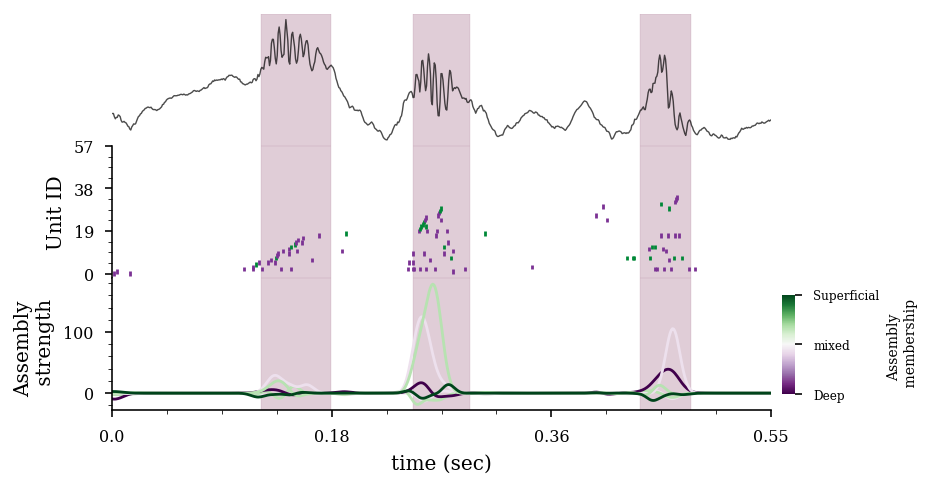

In [41]:
# from neurodsp.filt import filter_signal
import warnings

warnings.filterwarnings("ignore")

fig, axs = plt.subplots(
    3,
    1,
    figsize=functions.set_size("thesis", fraction=1, subplots=(1.5, 1.5)),
    edgecolor="k",
)
fig.subplots_adjust(hspace=0, wspace=0.2)
axs = axs.ravel()

# rip = 9
rip = 1358
rip = 71

window = 0.5
plotting_epoch = nel.EpochArray(
    [
        np.array(
            [
                ripple_epochs[rip].start - window / 2,
                ripple_epochs[rip].stop + window / 2,
            ]
        ).T
    ]
)

# Define a frequency range to filter the data
f_range = (100, 250)
# Bandpass filter the data, across the band of interest
# sig_filt = filter_signal(lfp_obj[plotting_epoch].data[channel_idx], fs, 'bandpass', f_range)
axs[0].plot(
    lfp_obj[plotting_epoch]._abscissa_vals,
    lfp_obj[plotting_epoch].data[channel_idx],
    color="k",
    alpha=0.7,
    linewidth=0.7,
    label="ripple bandpass filtered",
)

# sort by deepSuperficial
colors1 = np.array(["#7b3294"] * cell_metrics.shape[0])
colors1[cell_metrics.deepSuperficial == "Superficial"] = "#008837"
sort_idx = np.argsort(cell_metrics["deepSuperficial"])

fr_order = np.array(st_unit[plotting_epoch].get_event_firing_order()) - 1
axs[1].eventplot(
    st_unit[plotting_epoch].data[fr_order], color=colors1[fr_order], linelengths=2
)

deep_median = []
sup_median = []
for pattern in results["patterns_outside_ripples"]:
    deep_median.append(
        np.median(pattern[(results["deepSuperficial"] == "Deep") & (pattern > 0)])
    )
    sup_median.append(
        np.median(
            pattern[(results["deepSuperficial"] == "Superficial") & (pattern > 0)]
        )
    )

ratio = (np.array(sup_median) - np.array(deep_median)) / (
    np.array(sup_median) + np.array(deep_median)
)
norm = matplotlib.colors.Normalize(vmin=ratio.min(), vmax=ratio.max())
cmap = matplotlib.cm.get_cmap("PRGn")
rgba = cmap(norm(ratio))
for i, c in enumerate(rgba):
    axs[2].plot(
        assembly_act[plotting_epoch].abscissa_vals,
        assembly_act[plotting_epoch].data[i],
        color=c,
    )

axins = inset_axes(axs[2], width="2%", height="75%", loc="right", borderpad=-1.5)
sm = plt.cm.ScalarMappable(cmap="PRGn", norm=plt.Normalize(vmin=-1, vmax=1))
cbar = fig.colorbar(sm, cax=axins, ticks=[-1, 0, 1])
cbar.outline.set_visible(False)
cbar.ax.set_yticklabels(["Deep", "mixed", "Superficial"], fontsize=6)
axins.set_ylabel("Assembly \n membership", fontsize=7)

for rip in ripple_epochs[plotting_epoch]:
    axs[0].axvspan(rip.start, rip.stop, color="#843b62", alpha=0.25, zorder=-1000)
    axs[1].axvspan(rip.start, rip.stop, color="#843b62", alpha=0.25, zorder=-1000)
    axs[2].axvspan(rip.start, rip.stop, color="#843b62", alpha=0.25, zorder=-1000)

x = np.linspace(plotting_epoch.start, plotting_epoch.stop, 4)
axs[2].set_xticks(x)
axs[2].set_xticklabels(np.round(x - plotting_epoch.start, 2))

axs[1].set_yticks(np.linspace(0, cell_metrics.UID.unique().shape[0], 4))
axs[1].set_ylim(-2, cell_metrics.UID.unique().shape[0])
axs[1].set_ylabel("Unit ID")

axs[2].set_xlabel("time (sec)")
axs[2].set_ylabel("Assembly \n strength")

for i in range(3):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].set_xlim(plotting_epoch.start, plotting_epoch.stop)

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)

axs[1].spines["bottom"].set_visible(False)

axs[1].yaxis.set_minor_locator(AutoMinorLocator())
axs[2].yaxis.set_minor_locator(AutoMinorLocator())
axs[2].xaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(
    os.path.join(fig_save_path, "ripple_deep_sup_example_v2.svg"),
    dpi=300,
    bbox_inches="tight",
)


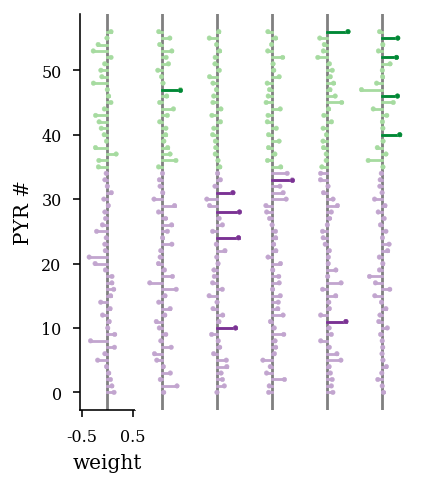

In [19]:
session = "Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\cell_assembly_v1\\Z__Data_AYAold_AB1_day1.pkl"
with open(session, "rb") as f:
    results = pickle.load(f)

# first, sort cells by sublayer
sort_idx = np.argsort(results["deepSuperficial"])
results["deepSuperficial"] = results["deepSuperficial"].iloc[sort_idx]

patterns = results["patterns_outside_ripples"]
patterns = [pat[sort_idx] for pat in patterns]
patterns = np.array(patterns)

# get colors per sub group
colors = ["#c2a5cf"] * results["deepSuperficial"].shape[0]
colors = np.array(colors)
colors[results["deepSuperficial"] == "Deep"] = ["#c2a5cf"] * sum(
    results["deepSuperficial"] == "Deep"
)
colors[results["deepSuperficial"] == "Superficial"] = ["#a6dba0"] * sum(
    results["deepSuperficial"] == "Superficial"
)

colors_sig = ["#7b3294"] * results["deepSuperficial"].shape[0]
colors_sig = np.array(colors_sig)
colors_sig[results["deepSuperficial"] == "Deep"] = ["#7b3294"] * sum(
    results["deepSuperficial"] == "Deep"
)
colors_sig[results["deepSuperficial"] == "Superficial"] = ["#008837"] * sum(
    results["deepSuperficial"] == "Superficial"
)


fig, axs = plt.subplots(
    1,
    patterns.shape[0],
    figsize=functions.set_size(
        "thesis", fraction=0.5, subplots=(patterns.shape[0], patterns.shape[0] / 2)
    ),
    edgecolor="k",
)

fig.subplots_adjust(hspace=0.00, wspace=0)
axs = axs.ravel()

for i, assmbl in enumerate(patterns):

    axs[i].scatter(assmbl, np.arange(len(assmbl)), c=colors, zorder=1000, s=5)

    thres = np.mean(assmbl) + np.std(assmbl) * 2
    idx = assmbl > thres
    axs[i].scatter(
        assmbl[idx], np.arange(len(assmbl))[idx], c=colors_sig[idx], zorder=1000, s=5
    )

    for j, item in enumerate(assmbl):
        axs[i].plot(np.sort([item, 0]), [j, j], color=colors[j], zorder=-50)
        if idx[j]:
            axs[i].plot(np.sort([item, 0]), [j, j], color=colors_sig[j], zorder=-50)

    axs[i].axvline(0, color="grey", zorder=-100)

    for i in range(patterns.shape[0]):
        axs[i].set_xlim(-patterns.max() - 0.1, patterns.max() + 0.1)

    for i in range(patterns.shape[0]):
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["top"].set_visible(False)

    for i in np.arange(1, patterns.shape[0]):
        axs[i].spines["left"].set_visible(False)
        axs[i].spines["bottom"].set_visible(False)
        axs[i].get_yaxis().set_ticks([])
        axs[i].get_xaxis().set_ticks([])

    axs[0].set_ylabel("PYR #")
    axs[0].set_xlabel("weight")
    axs[0].set_xticks([-0.5, 0.5])
    axs[0].set_xticklabels([-0.5, 0.5])

plt.savefig(
    os.path.join(fig_save_path, "assembly_weight_example.svg"),
    dpi=300,
    bbox_inches="tight",
)


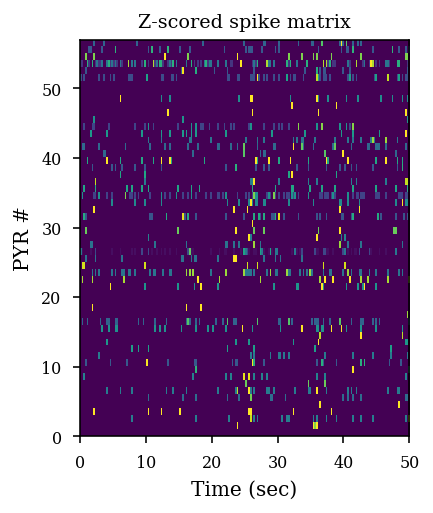

In [30]:
plt.figure(
    figsize=functions.set_size(
        "thesis", fraction=0.5, subplots=(patterns.shape[0], patterns.shape[0] / 2)
    ),
    edgecolor="k",
)
sort_idx = np.argsort(results["deepSuperficial"])

plt.imshow(
    results["zactmat_outside_ripples"][sort_idx, 2500:2700],
    aspect="auto",
    interpolation="nearest",
    origin="lower",
    extent=[0, 200 * 0.25, 0, patterns.shape[1]],
    vmax=5,
    vmin=0,
)
plt.ylabel("PYR #")
plt.xlabel("Time (sec)")
plt.title("Z-scored spike matrix")

# axs = plt.gca()
# for i, label in enumerate(('A')):
#     axs.text(-0.15, 1.2, label, transform=axs.transAxes,
#         fontsize=11, fontweight='normal', va='top', ha='right')

plt.savefig(
    os.path.join(fig_save_path, "assembly_zactmat_example.svg"),
    dpi=300,
    bbox_inches="tight",
)


## Pairwise corr of members and non members + deep/sup

In [50]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_wake_task"
assembly_corrs_deep_sup.assembly_corr_run(df, save_path, epoch="task", parallel=True, within_events=False)


### load in saved data

In [117]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_wake_task"

corr_df = pd.DataFrame()
sessions = glob.glob(save_path + os.sep + "*.csv")
for session in sessions:
    temp_df = pd.read_csv(session)
    corr_df = pd.concat([corr_df, temp_df], ignore_index=True)
corr_df


,Unnamed: 0,rho,label,assembly_id,basepath
0,0,-0.000358,sup,0.0,Z:\Data\AYAold\AYA4\day150804
1,1,-0.009056,sup,0.0,Z:\Data\AYAold\AYA4\day150804
2,2,-0.003696,sup,0.0,Z:\Data\AYAold\AYA4\day150804
3,3,-0.001823,sup,0.0,Z:\Data\AYAold\AYA4\day150804
4,4,-0.001287,sup,0.0,Z:\Data\AYAold\AYA4\day150804
...,...,...,...,...,...
1536090,1983,0.001598,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329
1536091,1984,0.183557,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329
1536092,1985,0.012389,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329
1536093,1986,0.008348,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329


Text(0, 0.5, 'Proportion of cells')

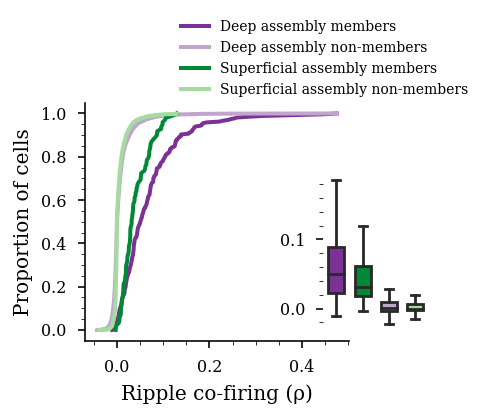

In [118]:
group_colors = {
    "member_deep": "#7b3294",
    "member_sup": "#008837",
    "non_member_deep": "#c2a5cf",
    "non_member_sup": "#a6dba0",
}

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1)), edgecolor="k"
)

axs = plt.gca()

idx = (
    (corr_df.label == "member_deep")
    | (corr_df.label == "non_member_deep")
    | (corr_df.label == "member_sup")
    | (corr_df.label == "non_member_sup")
)

custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "member_deep",
    axs,
    group_colors,
    linewidth=2,
    label="Deep assembly members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "non_member_deep",
    axs,
    group_colors,
    linewidth=2,
    label="Deep assembly non-members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "member_sup",
    axs,
    group_colors,
    linewidth=2,
    label="Superficial assembly members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "non_member_sup",
    axs,
    group_colors,
    linewidth=2,
    label="Superficial assembly non-members",
)

ax = custom_plots.plot_box(
    corr_df[idx], "label", "rho", axs, fig, group_colors, x_offset=0.7, showfliers=False
)

axs.legend(
    loc="best", bbox_to_anchor=(1, 0.0, 0.5, 1.4), fontsize="x-small", frameon=False
)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_xlabel("Ripple co-firing (ρ)")
axs.set_ylabel("Proportion of cells")

# plt.savefig(os.path.join(fig_save_path,'assembly_member_correlation.svg'),dpi=300,bbox_inches='tight')


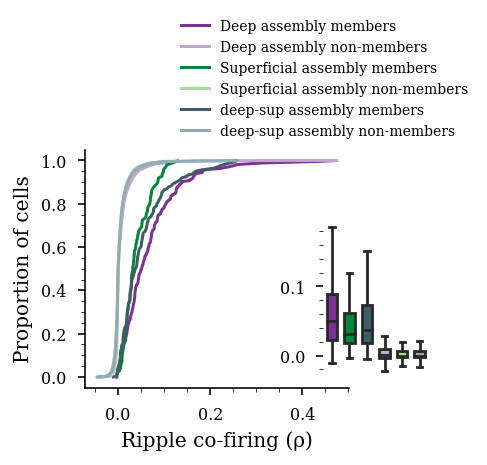

In [119]:
group_colors = {
    "member_deep": "#7b3294",
    "member_sup": "#008837",
    "member_deep_sup": "#3e5d66",
    "non_member_deep": "#c2a5cf",
    "non_member_sup": "#a6dba0",
    "non_member_deep_sup": "#91abb3",
}

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1)), edgecolor="k"
)

axs = plt.gca()

idx = (
    (corr_df.label == "member_deep")
    | (corr_df.label == "non_member_deep")
    | (corr_df.label == "member_sup")
    | (corr_df.label == "non_member_sup")
    | (corr_df.label == "member_deep_sup")
    | (corr_df.label == "non_member_deep_sup")
)

custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "member_deep",
    axs,
    group_colors,
    linewidth=1.5,
    label="Deep assembly members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "non_member_deep",
    axs,
    group_colors,
    linewidth=1.5,
    label="Deep assembly non-members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "member_sup",
    axs,
    group_colors,
    linewidth=1.5,
    label="Superficial assembly members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "non_member_sup",
    axs,
    group_colors,
    linewidth=1.5,
    label="Superficial assembly non-members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "member_deep_sup",
    axs,
    group_colors,
    linewidth=1.5,
    label="deep-sup assembly members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "non_member_deep_sup",
    axs,
    group_colors,
    linewidth=1.5,
    label="deep-sup assembly non-members",
)

ax = custom_plots.plot_box(
    corr_df[idx], "label", "rho", axs, fig, group_colors, x_offset=0.7, showfliers=False
)

axs.legend(
    loc="best", bbox_to_anchor=(1, 0.0, 0.5, 1.6), fontsize="x-small", frameon=False
)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_xlabel("Ripple co-firing (ρ)")
axs.set_ylabel("Proportion of cells")

plt.savefig(
    os.path.join(fig_save_path, "assembly_member_correlation_wake_task.svg"),
    dpi=300,
    bbox_inches="tight",
)


## add factors

In [120]:
# for i,basepath in enumerate(corr_df.basepath):
idx = (
    (corr_df.label == "non_member_deep")
    | (corr_df.label == "non_member_sup")
    | (corr_df.label == "non_member_deep_sup")
)
corr_df["membership"] = "member"
corr_df.loc[idx, "membership"] = "non_member"
corr_df


,Unnamed: 0,rho,label,assembly_id,basepath,membership
0,0,-0.000358,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member
1,1,-0.009056,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member
2,2,-0.003696,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member
3,3,-0.001823,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member
4,4,-0.001287,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member
...,...,...,...,...,...,...
1536090,1983,0.001598,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329,non_member
1536091,1984,0.183557,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329,non_member
1536092,1985,0.012389,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329,non_member
1536093,1986,0.008348,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329,non_member


In [121]:
# importlib.reload(loading)
corr_df["name"] = "unknown"
for basepath in corr_df.basepath.unique():
    corr_df.loc[corr_df.basepath == basepath, "name"] = loading.get_animal_id(basepath)
corr_df


,Unnamed: 0,rho,label,assembly_id,basepath,membership,name
0,0,-0.000358,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member,AYA4
1,1,-0.009056,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member,AYA4
2,2,-0.003696,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member,AYA4
3,3,-0.001823,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member,AYA4
4,4,-0.001287,sup,0.0,Z:\Data\AYAold\AYA4\day150804,member,AYA4
...,...,...,...,...,...,...,...
1536090,1983,0.001598,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329,non_member,nlx
1536091,1984,0.183557,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329,non_member,nlx
1536092,1985,0.012389,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329,non_member,nlx
1536093,1986,0.008348,non_member_deep,195.0,Z:\Data\Kenji\nlx_070329,non_member,nlx


In [124]:
idx = (
    (corr_df.label == "member_deep")
    | (corr_df.label == "non_member_deep")
    | (corr_df.label == "member_sup")
    | (corr_df.label == "non_member_sup")
    | (corr_df.label == "member_deep_sup")
    | (corr_df.label == "non_member_deep_sup")
)
bad_idx = np.isnan(corr_df[idx].rho) | np.isinf(corr_df[idx].rho)

data = corr_df[idx & ~bad_idx]
# check if folder exist
folder = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_wake_task\results"
if not os.path.exists(folder):
    os.mkdir(folder)

data.to_csv(
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_wake_task\results\df.csv"
)


In [125]:
# corr_df.label.unique()
corr_df["label_2"] = "unknown"
idx = (corr_df.label == "member_deep") | (corr_df.label == "member_sup")
corr_df.loc[idx, "label_2"] = "member_same_layer"

idx = corr_df.label == "member_deep_sup"
corr_df.loc[idx, "label_2"] = "member_cross_layer"

idx = (
    (corr_df.label == "non_member_deep")
    | (corr_df.label == "non_member_sup")
    | (corr_df.label == "non_member_deep_sup")
)
corr_df.loc[idx, "label_2"] = "non_member"


(0.0, 1.0)

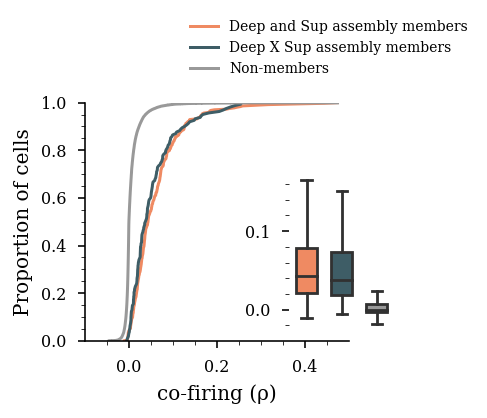

In [126]:
group_colors = {
    "member_same_layer": "#ef8a62",
    "member_cross_layer": "#3e5d66",
    "non_member": "#999999",
}


fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1)), edgecolor="k"
)

axs = plt.gca()

idx = (
    (corr_df.label == "member_deep")
    | (corr_df.label == "non_member_deep")
    | (corr_df.label == "member_sup")
    | (corr_df.label == "non_member_sup")
    | (corr_df.label == "member_deep_sup")
    | (corr_df.label == "non_member_deep_sup")
)

custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label_2",
    "member_same_layer",
    axs,
    group_colors,
    linewidth=1.5,
    label="Deep and Sup assembly members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label_2",
    "member_cross_layer",
    axs,
    group_colors,
    linewidth=1.5,
    label="Deep X Sup assembly members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label_2",
    "non_member",
    axs,
    group_colors,
    linewidth=1.5,
    label="Non-members",
)

ax = custom_plots.plot_box(
    corr_df[idx],
    "label_2",
    "rho",
    axs,
    fig,
    group_colors,
    x_offset=0.6,
    showfliers=False,
)

axs.legend(
    loc="best", bbox_to_anchor=(1, -0.2, 0.5, 1.6), fontsize="x-small", frameon=False
)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_xlabel("co-firing (cor)")
axs.set_ylabel("Proportion of cells")
axs.set_xlim([-0.1, .5])
axs.set_ylim([0, 1])

# plt.savefig(
#     os.path.join(fig_save_path, "assembly_member_correlation_wake_task.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )


Text(0, 0.5, 'Proportion of cells')

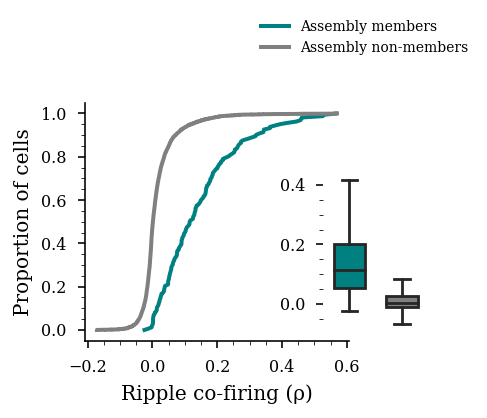

In [44]:
group_colors = {"member_deep_sup": "teal", "non_member_deep_sup": "grey"}

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1)), edgecolor="k"
)

axs = plt.gca()

idx = (corr_df.label == "member_deep_sup") | (corr_df.label == "non_member_deep_sup")

custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "member_deep_sup",
    axs,
    group_colors,
    linewidth=2,
    label="Assembly members",
)
custom_plots.plot_ecdf(
    "rho",
    corr_df[idx],
    "label",
    "non_member_deep_sup",
    axs,
    group_colors,
    linewidth=2,
    label="Assembly non-members",
)

ax = custom_plots.plot_box(
    corr_df[idx], "label", "rho", axs, fig, group_colors, x_offset=0.7, showfliers=False
)

axs.legend(
    loc="best", bbox_to_anchor=(1, 0.0, 0.5, 1.4), fontsize="x-small", frameon=False
)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_xlabel("Ripple co-firing (ρ)")
axs.set_ylabel("Proportion of cells")

# plt.savefig(os.path.join(fig_save_path,'assembly_member_correlation.svg'),dpi=300,bbox_inches='tight')
